In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Read the cleaned dataset
final_df = pd.read_csv('/content/drive/MyDrive/Dataset/clean_final_df.csv')


## Question 1

##Analysis Based on OEE Productivity

In [ ]:
group_cols = ["LINE_NAME", "PRODUCTIONDATE_DAY_LOC", "SHIFT_NAME"]


# Group necessary variables
grouped = (
    final_df.groupby(group_cols, as_index=False)
    .agg({
        'RUN_TIME': 'sum',
        'PRODUCTION_AVAILABLE_TIME': 'sum',
        'GOOD_PRODUCTION_QTY': 'sum',
        'REJECT_PRODUCTION_QTY': 'sum',
        'PRODUCTION_ORDER_RATE': 'mean',
        'Ideal_cycle_time': 'mean',
        'Total_Production_Qty': 'sum'
    })
)

# Filter necessary conditions, since we only accounts for machines that are actually running
grouped = grouped[
    (grouped['PRODUCTION_AVAILABLE_TIME'] > 0) &
    (grouped['RUN_TIME'] > 0) &
    (grouped['Total_Production_Qty'] > 0)
]


In [ ]:
# Calculate OEE components
grouped['Availability'] = grouped['RUN_TIME'] / grouped['PRODUCTION_AVAILABLE_TIME']
grouped['Performance'] = (grouped['Ideal_cycle_time'] * grouped['Total_Production_Qty']) / grouped['RUN_TIME']
grouped['Quality'] = grouped['GOOD_PRODUCTION_QTY'] / grouped['Total_Production_Qty']

# Calculate OEE
grouped['OEE'] = grouped['Availability'] * grouped['Performance'] * grouped['Quality']

# Final OEE dataframe
OEE_df = grouped[group_cols + ['Availability', 'Performance', 'Quality', 'OEE']]

In [ ]:
grouped

,LINE_NAME,PRODUCTIONDATE_DAY_LOC,SHIFT_NAME,RUN_TIME,PRODUCTION_AVAILABLE_TIME,GOOD_PRODUCTION_QTY,REJECT_PRODUCTION_QTY,PRODUCTION_ORDER_RATE,Ideal_cycle_time,Total_Production_Qty,Availability,Performance,Quality,OEE
3,MAFT2201,2025-01-02,Afternoon-2,333,412,7584,469,17.454545,0.030303,8053,0.808252,0.732824,0.941761,0.557811
4,MAFT2201,2025-01-02,Day-1,296,418,6528,677,16.000000,0.027778,7205,0.708134,0.676145,0.906037,0.433812
5,MAFT2201,2025-01-02,Night-3,330,395,7488,587,15.000000,0.026042,8075,0.835443,0.637232,0.927307,0.493671
6,MAFT2201,2025-01-03,Afternoon-2,368,422,8496,168,21.818182,0.026515,8664,0.872038,0.624259,0.980609,0.533822
7,MAFT2201,2025-01-03,Day-1,328,428,7344,409,16.000000,0.027778,7753,0.766355,0.656589,0.947246,0.476636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28118,MKZA1802,2025-05-22,Night-3,445,461,29400,219,44.666667,0.009950,29619,0.965293,0.662284,0.992606,0.634571
28119,MKZA1802,2025-05-23,Afternoon-2,441,441,29100,236,26.800000,0.005970,29336,1.000000,0.397144,0.991955,0.393949
28120,MKZA1802,2025-05-23,Day-1,422,456,27900,498,67.000000,0.009328,28398,0.925439,0.627741,0.982464,0.570748
28121,MKZA1802,2025-05-23,Night-3,442,453,29200,147,40.200000,0.008955,29347,0.975717,0.594590,0.994991,0.577246


<Axes: >

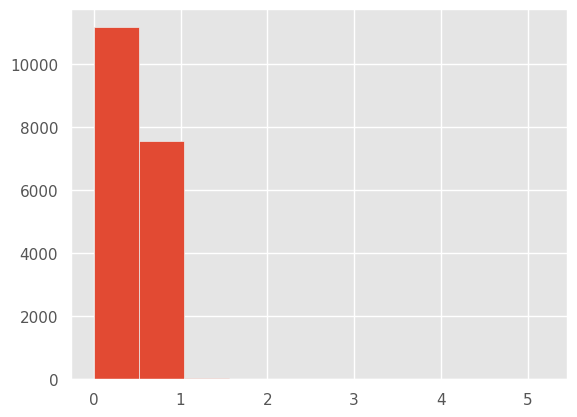

In [ ]:
# Check the distribution of OEE
OEE_df['OEE'].hist()

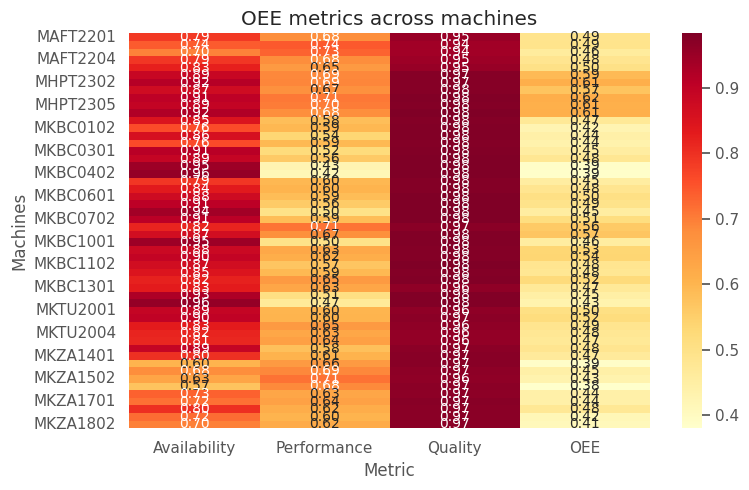

In [ ]:
# Calculate average OEE metrics by line
oee_metrics = (
    OEE_df.groupby('LINE_NAME')[['Availability', 'Performance', 'Quality', 'OEE']]
    .mean()
    .reset_index()
)

plt.figure(figsize=(8,5))
sns.heatmap(oee_metrics.set_index('LINE_NAME')[['Availability','Performance','Quality','OEE']],
            annot=True, fmt=".2f", cmap='YlOrRd')
plt.title('OEE metrics across machines')
plt.xlabel('Metric')
plt.ylabel('Machines')
plt.tight_layout()
plt.show()

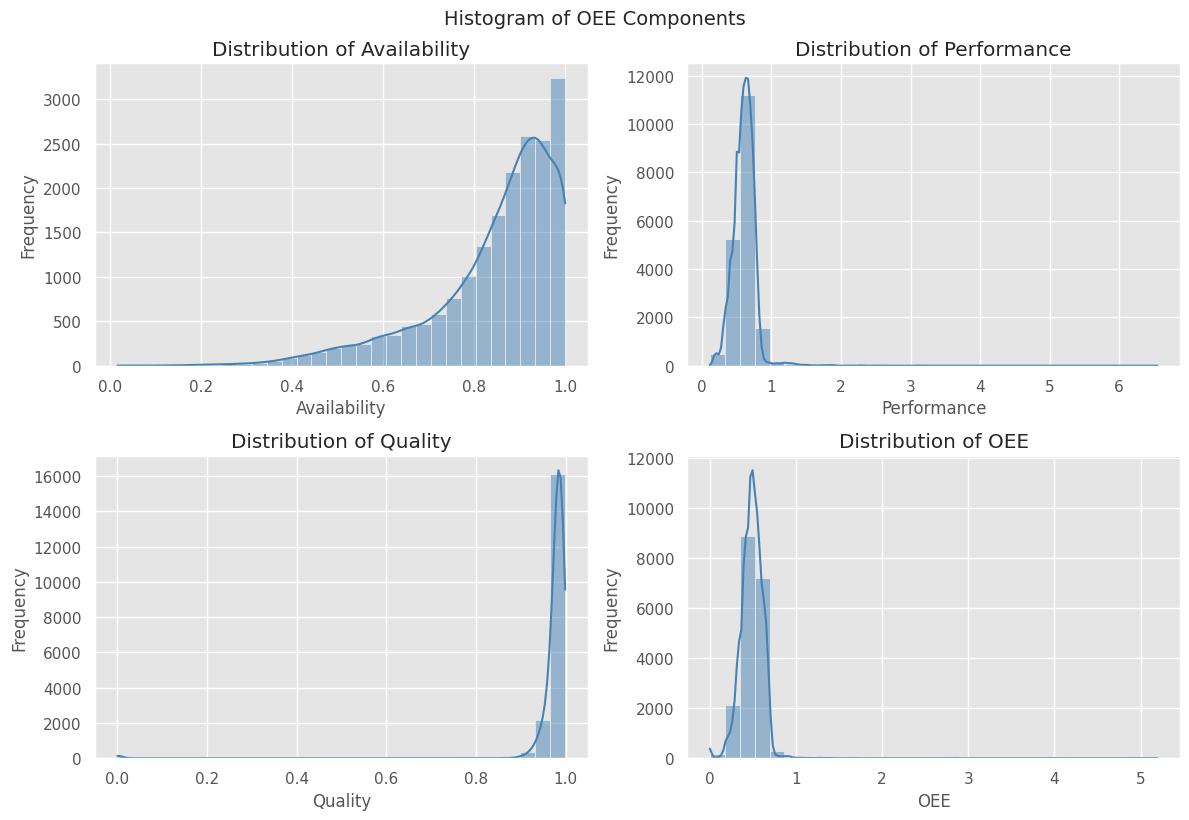

In [ ]:
cols = ['Availability', 'Performance', 'Quality', 'OEE']

plt.figure(figsize=(12, 8))
for i, col in enumerate(cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(grouped[col], kde=True, bins=30, color='steelblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.suptitle('Histogram of OEE Components', fontsize=14, y=1.02)
plt.show()

## Product Defect Rate and Production Throughput Yield Analysis

In [ ]:
defect_rate_df = (
    final_df.groupby(group_cols, as_index=False)
    .agg({
        'GOOD_PRODUCTION_QTY': 'sum',
        'REJECT_PRODUCTION_QTY': 'sum'
    })
)

# Calculate total product manufactured
defect_rate_df['Total_Production_Qty'] = defect_rate_df['GOOD_PRODUCTION_QTY'] + defect_rate_df['REJECT_PRODUCTION_QTY']

# Filter necessary condition
defect_rate_df = defect_rate_df[defect_rate_df['Total_Production_Qty'] > 0]

# Calculate defect rate
defect_rate_df['Defect_Rate'] = defect_rate_df['REJECT_PRODUCTION_QTY'] / defect_rate_df['Total_Production_Qty']

In [ ]:
# === Calculate Production Throughput Yield ===
pty_df = (
    final_df.groupby(group_cols, as_index=False)
    .agg({
        'GOOD_PRODUCTION_QTY': 'sum',
        'REJECT_PRODUCTION_QTY': 'sum'
    })
)

pty_df['Total_Output'] = pty_df['GOOD_PRODUCTION_QTY'] + pty_df['REJECT_PRODUCTION_QTY']
pty_df = pty_df[pty_df['Total_Output'] > 0]
pty_df['Production_Throughput_Yield'] = pty_df['GOOD_PRODUCTION_QTY'] / pty_df['Total_Output']

In [ ]:
downtime_df = (
    final_df
    .groupby(group_cols, as_index=False)
    .agg(
        total_downtime=('DOWNTIME', 'sum'),
        total_available_time=('PRODUCTION_AVAILABLE_TIME', 'sum'),
    )
    .assign(
        downtime_rate=lambda x: x['total_downtime'] / x['total_available_time']
    )
    .drop(columns='total_available_time')
)

# --- Merge all necessary tables ---
merged_metrics = (
    OEE_df
    .merge(defect_rate_df[group_cols + ['Defect_Rate']], on=group_cols, how='left')
    .merge(pty_df[group_cols + ['Production_Throughput_Yield']], on=group_cols, how='left')
    .merge(downtime_df[group_cols + ['total_downtime', 'downtime_rate']], on=group_cols, how='left')
)

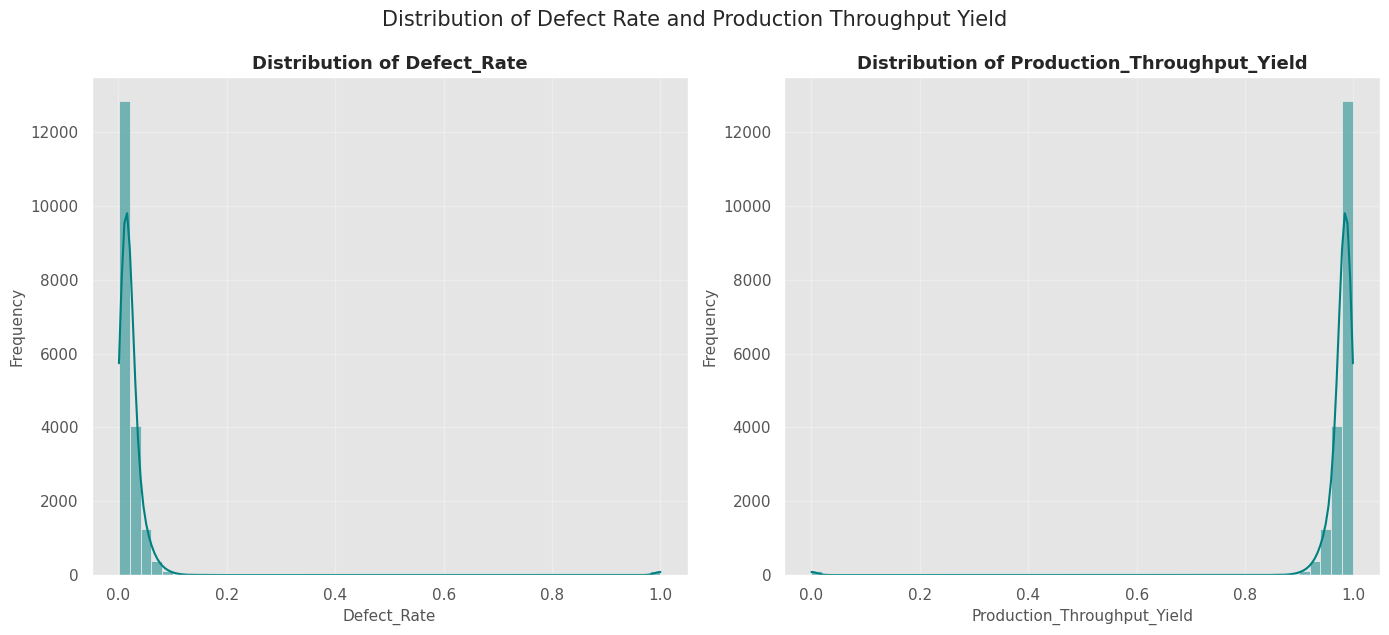

In [ ]:
cols_defect_pty = ['Defect_Rate', 'Production_Throughput_Yield']

plt.figure(figsize=(14, 6))
for i, col in enumerate(cols_defect_pty, 1):
    plt.subplot(1, 2, i)
    sns.histplot(merged_metrics[col], kde=True, bins=50, color='teal')
    plt.title(f'Distribution of {col}', fontsize=13, weight='bold')
    plt.xlabel(col, fontsize=11)
    plt.ylabel('Frequency', fontsize=11)
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.suptitle('Distribution of Defect Rate and Production Throughput Yield', fontsize=15, y=1.05)
plt.show()

## Question 2

## PART 2: ROOT CAUSE ANALYSIS

## A. Root cause by shift name

### A1. OEE analysis of shift name based on time trend

/tmp/ipython-input-1935614907.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OEE_df['PRODUCTIONDATE_DAY_LOC'] = pd.to_datetime(OEE_df['PRODUCTIONDATE_DAY_LOC'])


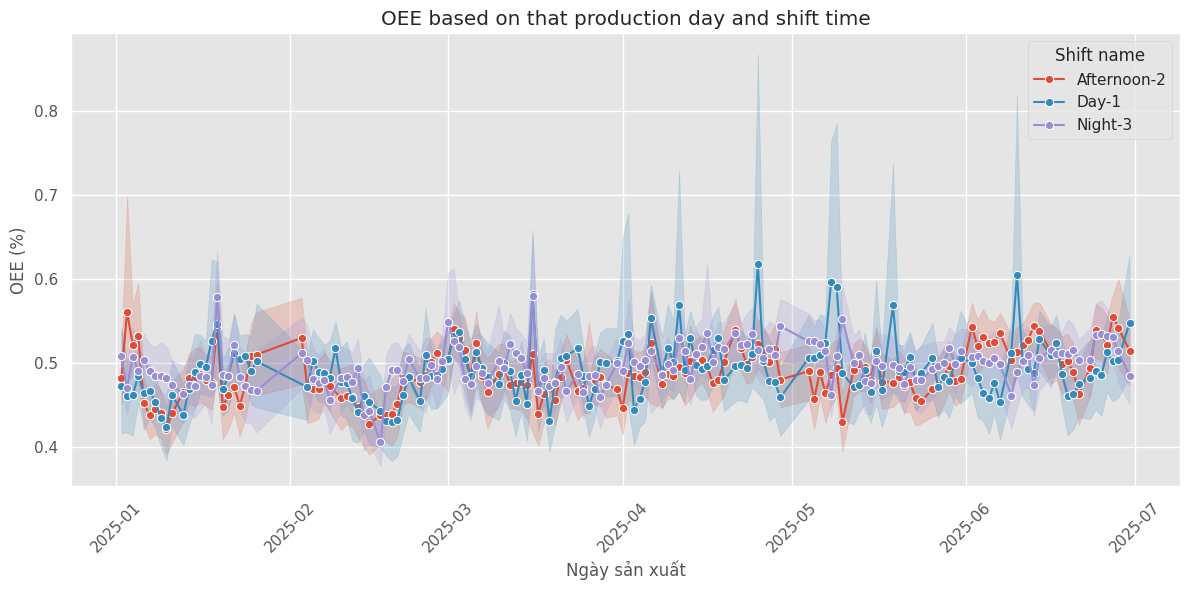

In [ ]:
OEE_df['PRODUCTIONDATE_DAY_LOC'] = pd.to_datetime(OEE_df['PRODUCTIONDATE_DAY_LOC'])

plt.figure(figsize=(12, 6))
sns.lineplot(data=OEE_df, x='PRODUCTIONDATE_DAY_LOC', y='OEE', hue='SHIFT_NAME', marker='o')
plt.title('OEE based on that production day and shift time')
plt.xlabel('Ngày sản xuất')
plt.ylabel('OEE (%)')
plt.legend(title='Shift name')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

From this given chart, we can see that OEE is around 0.49-0.5, with OEE for day time in the morning has higher OEE than OEE in afternoon and night

### A2. Downtime rate of shift name based on time trend

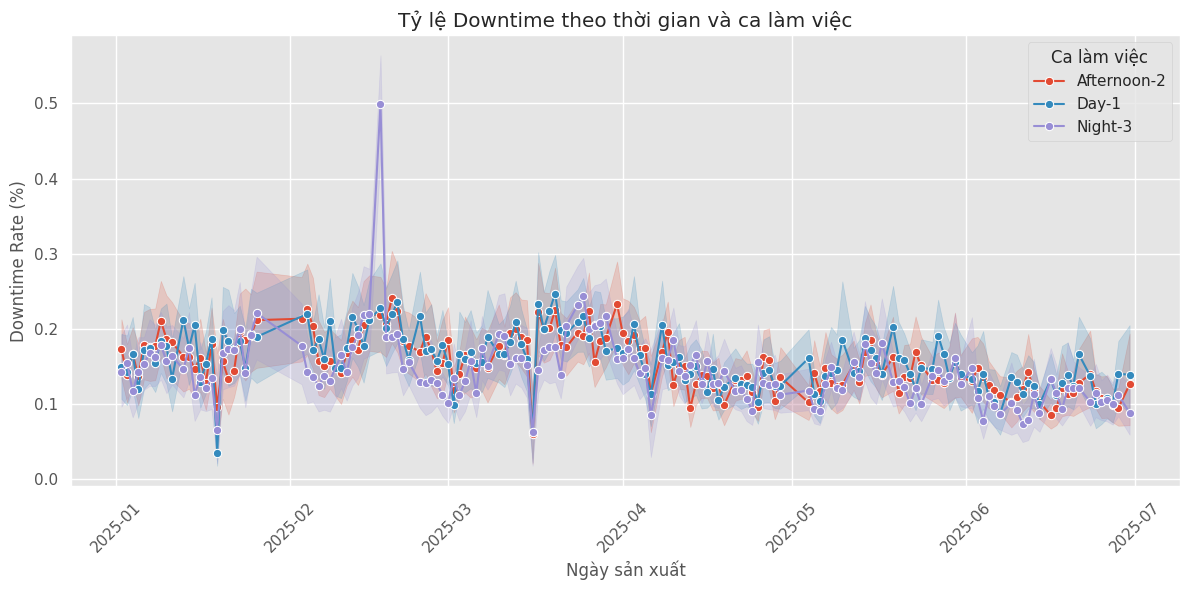

In [ ]:
downtime_df['PRODUCTIONDATE_DAY_LOC'] = pd.to_datetime(downtime_df['PRODUCTIONDATE_DAY_LOC'])

plt.figure(figsize=(12, 6))
sns.lineplot(data=downtime_df, x='PRODUCTIONDATE_DAY_LOC', y='downtime_rate', hue='SHIFT_NAME', marker='o')
plt.title('Tỷ lệ Downtime theo thời gian và ca làm việc')
plt.xlabel('Ngày sản xuất')
plt.ylabel('Downtime Rate (%)')
plt.legend(title='Ca làm việc')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- Overall, the downtime rate for all three shifts generally fluctuates between 10% and 20%.

- There is a significant outlier in early February 2025, where the Night shift's downtime spiked dramatically to 50% before returning to normal levels. Apart from this specific event, the performance of the three shifts is largely comparable

### A3. Defect Rates by Shift

/tmp/ipython-input-368359466.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=defect_by_shift.values, y=defect_by_shift.index, palette='Purples_r')


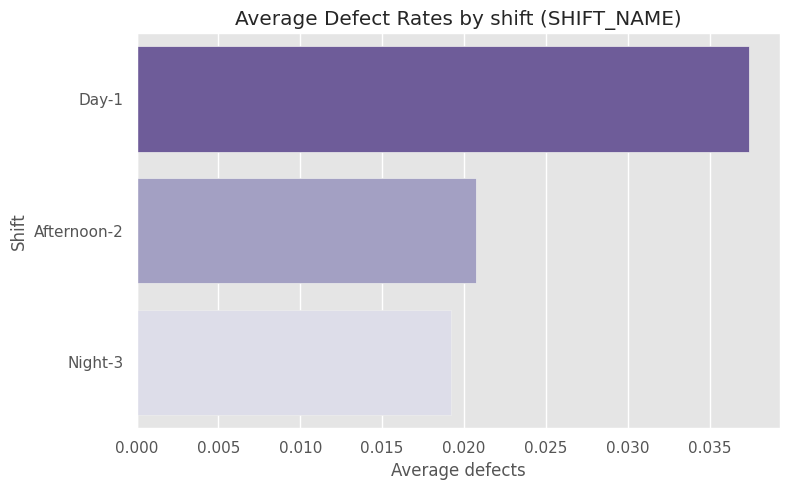

In [ ]:
# Calculate defect rate based on total production quantity in the grouped dataframe
grouped['Defect_Rate'] = grouped['REJECT_PRODUCTION_QTY'] / (
    grouped['GOOD_PRODUCTION_QTY'] + grouped['REJECT_PRODUCTION_QTY']
)

defect_by_shift = (
    grouped.groupby('SHIFT_NAME')['Defect_Rate']
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(8, 5))
sns.barplot(x=defect_by_shift.values, y=defect_by_shift.index, palette='Purples_r')
plt.title('Average Defect Rates by shift (SHIFT_NAME)')
plt.xlabel('Average defects')
plt.ylabel('Shift')
plt.tight_layout()
plt.show()

From the bar chart, we can see that during daytime, the possibility of defect rates is the highest

## B. Root cause analysis based on machine

## B1. Top 10 Machines that has the lowest OEE

/tmp/ipython-input-563586956.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_lines.values, y=top_lines.index, palette='viridis')


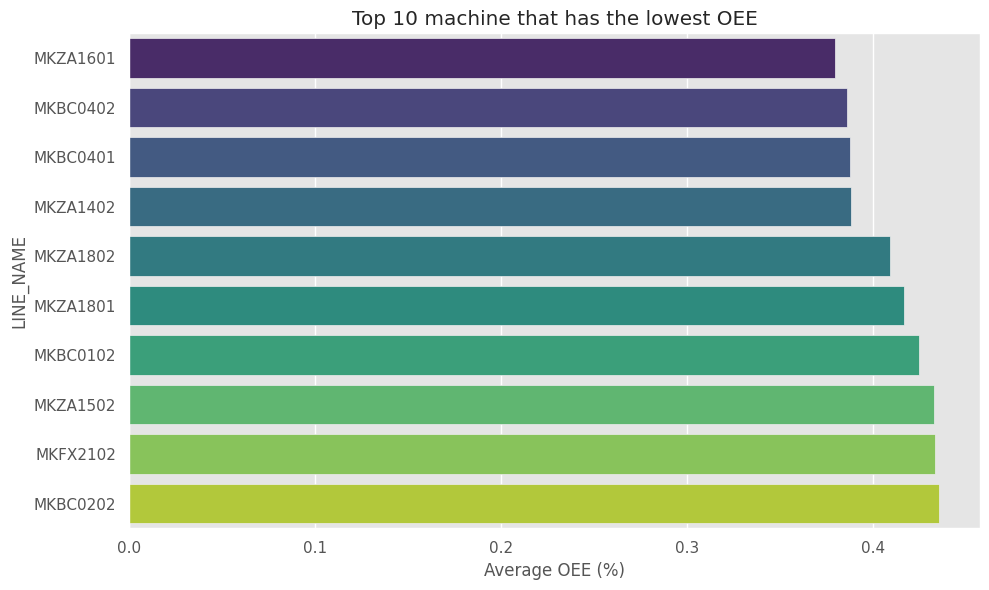

In [ ]:
top_lines = (
    OEE_df.groupby('LINE_NAME')['OEE']
    .mean()
    .sort_values(ascending=True)
    .head(10)
)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_lines.values, y=top_lines.index, palette='viridis')
plt.title('Top 10 machine that has the lowest OEE')
plt.xlabel('Average OEE (%)')
plt.ylabel('LINE_NAME')
plt.tight_layout()
plt.show()

The data indicates that:

- The machine with the lowest OEE (MKZA1601) is noticeably lagging behind the rest.

- The OEE values for this bottom 10 group range from about 0.38 to 0.44 (38% to 44%).

- Machines MKBC0202, MKFX2102, and MKZA1502 have the highest OEE in this "lowest OEE" group, all around 0.44.

- Precision Grip 2.0 has the absolute lowest OEE, at approximately 0.38 (or 38%).

- The three products with the worst performance—Precision Grip 2.0, Zenith Classic Clean, and ActiveClean Model X—are tightly clustered around $38\%-39\%$.
- The OEE across the bottom 10 products is relatively low, ranging from about 0.38 to 0.45 (38% to 45%). Even the "best" product in this group, Advanced Hydro-Clean, needs significant improvement.

## B2. Top 10 machines that has the highest downtime rate

/tmp/ipython-input-1177477028.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_machines.values, y=top_machines.index, palette='flare')


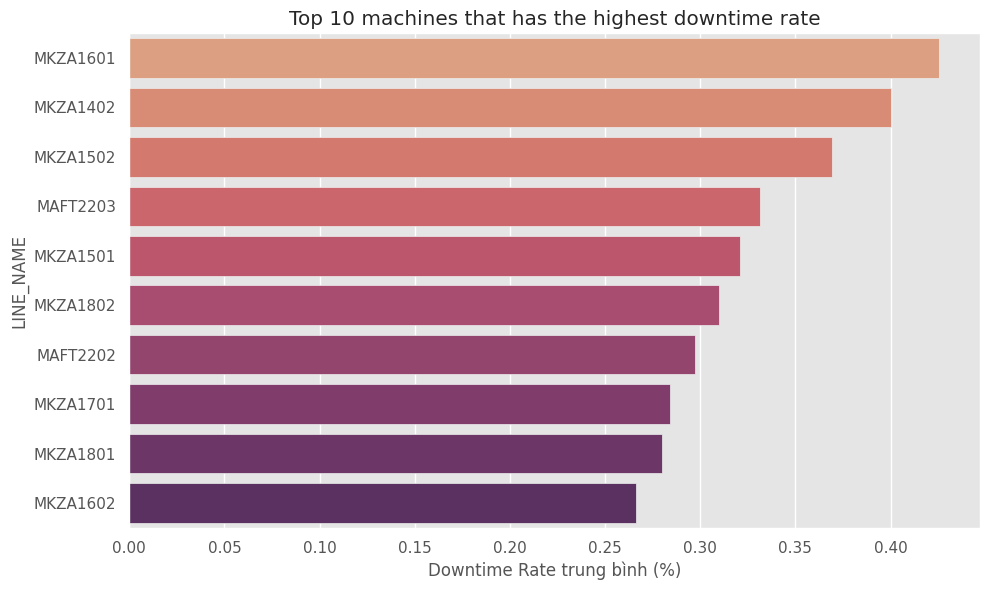

In [ ]:
top_machines = (
    downtime_df.groupby('LINE_NAME')['downtime_rate']
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_machines.values, y=top_machines.index, palette='flare')
plt.title('Top 10 machines that has the highest downtime rate')
plt.xlabel('Downtime Rate trung bình (%)')
plt.ylabel('LINE_NAME')
plt.tight_layout()
plt.show()

* MKZA1601 has the highest downtime rate, at approximately 0.42 (or 42%).
* The top three machines—MKZA1601, MKZA1402, and MKZA1502—are the worst performers, with downtime rates ranging from about 37% to 42%.
* There is a significant gap between the highest rate (MKZA1601) and the lowest rate in this top 10 (MKZA1602 at around 27% )

## B3. Defect Rates by Machines

/tmp/ipython-input-1451284731.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=defect_by_line.values, y=defect_by_line.index, palette='Reds_r')


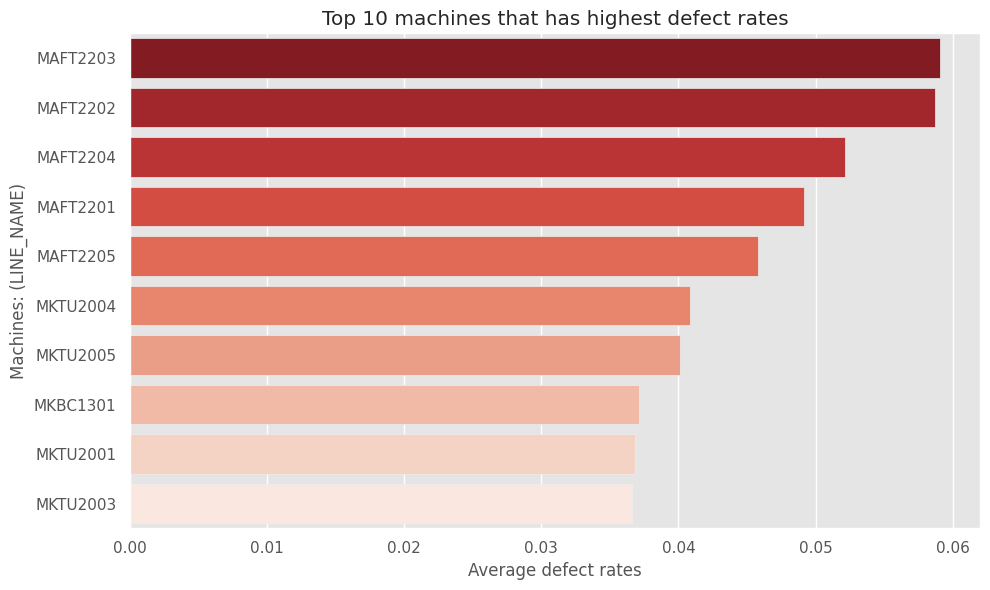

In [ ]:
grouped['Defect_Rate'] = grouped['REJECT_PRODUCTION_QTY'] / (
    grouped['GOOD_PRODUCTION_QTY'] + grouped['REJECT_PRODUCTION_QTY']
)

# Calculate defect rate based on machines
defect_by_line = (
    grouped.groupby('LINE_NAME')['Defect_Rate']
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(10, 6))
sns.barplot(x=defect_by_line.values, y=defect_by_line.index, palette='Reds_r')
plt.title('Top 10 machines that has highest defect rates')
plt.xlabel('Average defect rates')
plt.ylabel('Machines: (LINE_NAME)')
plt.tight_layout()
plt.show()

Machines MAFT2203 and MAFT2202 have the highest Defect Rates, around 6%, making them the primary sources of poor quality output and major contributors to the overall Rework problem

### B3. Analysis of changeover metrics
A production line with a low planned maintenance percentage → experiences more unplanned downtime → needs increased preventive maintenance.

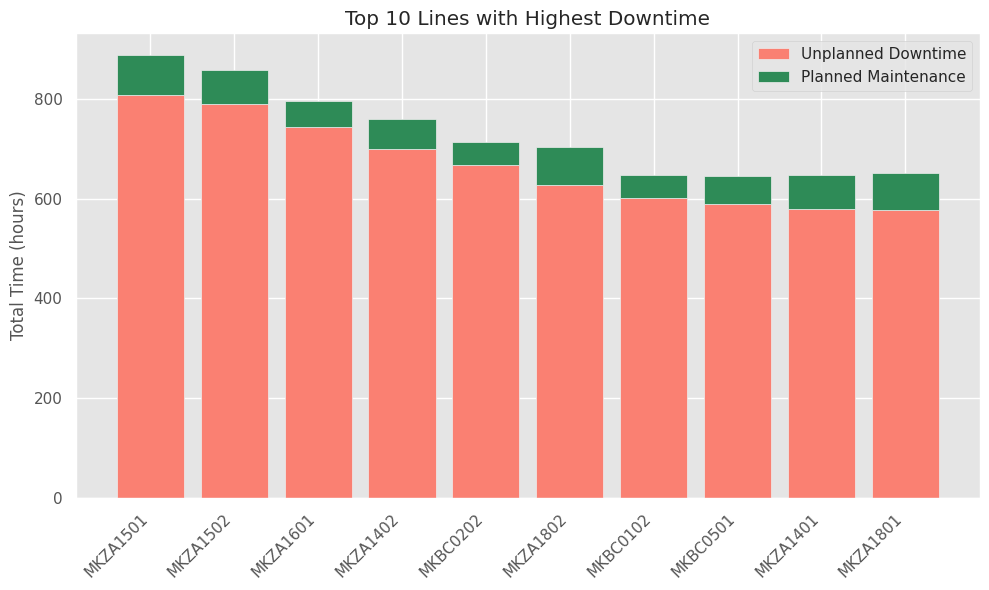

In [ ]:
changeover_metrics = (
    final_df.groupby('LINE_NAME')
    .agg(
        avg_changeover=('CHANGEOVER_DURATION', 'mean'),
        changeover_freq=('CO_TYPE', 'count'),
        planned_maintenance=('PLANNED_MAINTENANCE', 'sum'),
        unplanned_downtime=('DOWNTIME', 'sum')
    )
    .assign(
        planned_maintenance_pct=lambda x: x['planned_maintenance'] / (
            x['planned_maintenance'] + x['unplanned_downtime']
        )
    )
)

top10 = changeover_metrics.sort_values('unplanned_downtime', ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.bar(top10.index, top10['unplanned_downtime']/60, color='salmon', label='Unplanned Downtime')
plt.bar(top10.index, top10['planned_maintenance']/60, bottom=top10['unplanned_downtime']/60, color='seagreen', label='Planned Maintenance')

plt.title("Top 10 Lines with Highest Downtime")
plt.ylabel("Total Time (hours)")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
production_df.columns

Index(['PRODUCTIONDATE_DAY_LOC', 'SHIFT_NAME', 'LINE_NAME', 'CO_TYPE',
       'CREW_ID', 'AE_MODEL_CATEGORY', 'SIZE_TYPE', 'SHIFT_NAME.1',
       'UTIL_REASON_DESCRIPTION', 'DOWNTIME', 'EFFECTIVE_RUNTIME',
       'GOOD_PRODUCTION_QTY', 'LUNCH_AND_BREAK', 'MEETING_AND_TRAINING',
       'NO_DEMAND', 'PLANT_AVAILABLE_TIME', 'PLANT_EXPERIMENTATION',
       'PRODUCTION_AVAILABLE_TIME', 'REJECT_PRODUCTION_QTY', 'RUN_TIME',
       'CHANGEOVER_DURATION', 'CLEANING_AND_SANITIZATION',
       'BUSINESS_EXTERNAL_TIME', 'PLANNED_MAINTENANCE', 'TOTAL_TIME',
       'WAITING_TIME', 'PRODUCTION_ORDER_RATE'],
      dtype='object')

- **Highest Downtime:** MKZA1501 has the highest total downtime, exceeding 850 hours.

- **Unplanned Downtime Dominance**: For virtually all lines, Unplanned Downtime (the red bars) makes up the vast majority of the total time loss. This indicates that operational instability and equipment failures are the primary drivers of lost production.

=>  Improvement efforts should be immediately focused on reducing unplanned events on the top three lines: MKZA1501, MKZA1502, and MKZA1601.

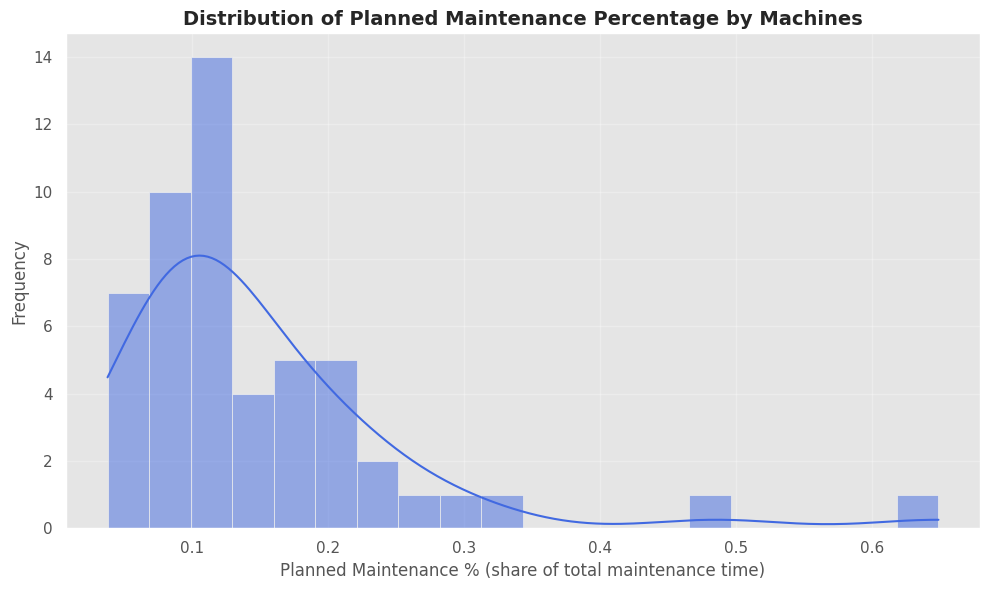

In [ ]:
plt.figure(figsize=(10,6))

# Histogram (phân phối phần trăm bảo trì)
sns.histplot(changeover_metrics['planned_maintenance_pct'], bins=20, kde=True, color='royalblue')
plt.title('Distribution of Planned Maintenance Percentage by Machines', fontsize=14, fontweight='bold')
plt.xlabel('Planned Maintenance % (share of total maintenance time)')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

- Distribution Shape: The distribution is highly right-skewed. This means that for the majority of lines, planned maintenance constitutes a very small fraction (less than $20\%$) of the total maintenance time.Low Planned

- The vast majority of production lines are operating with a low planned maintenance ratio, signaling that maintenance resources are primarily dedicated to addressing failures rather than preventing them. This reactive approach likely contributes to high downtime, as observed in previous graphs

### MTBF and MTTR based on machines

/tmp/ipython-input-2110107687.py:25: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


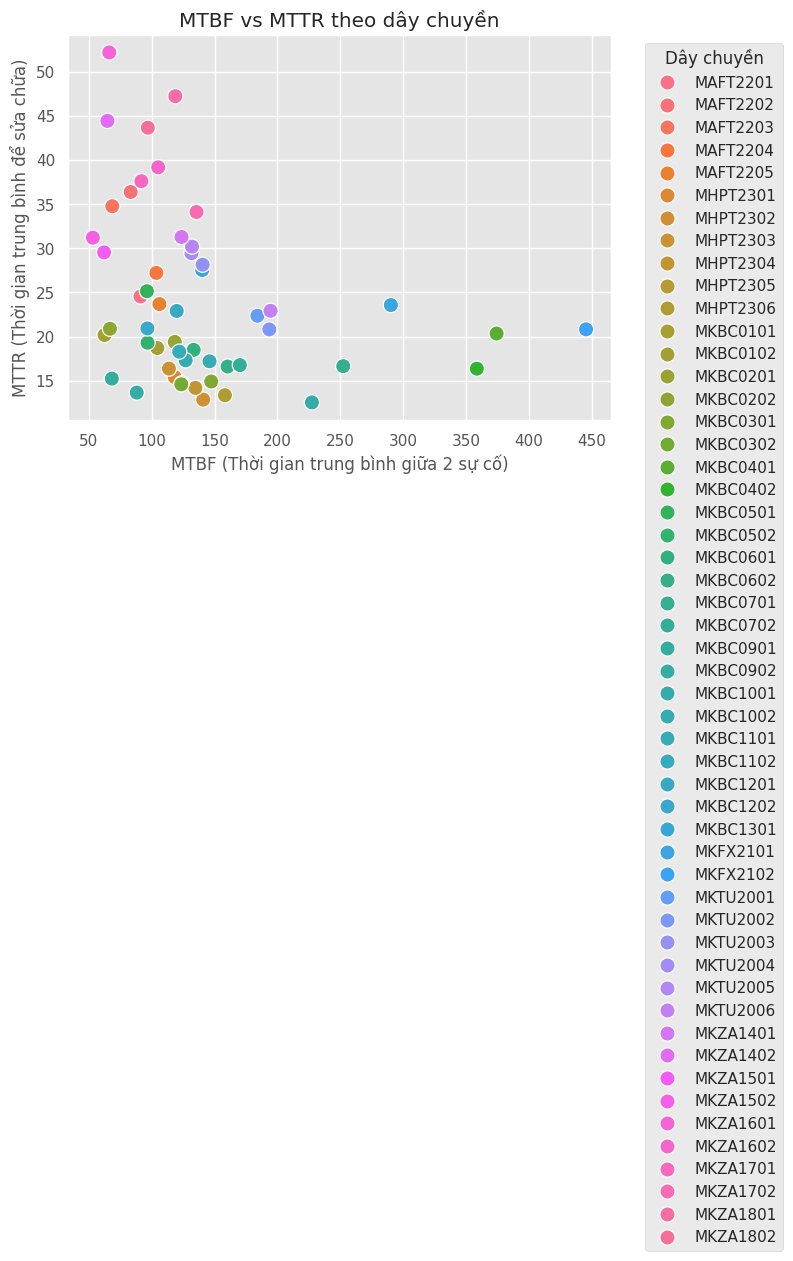

In [ ]:
# Group và tính toán với điều kiện downtime > 0
mtbf_mttr = (
    final_df.groupby('LINE_NAME')
    .agg(
        total_downtime=('DOWNTIME', 'sum'),
        total_runtime=('RUN_TIME', 'sum'),
        # Đếm số lần thực sự có downtime > 0
        downtime_events=('DOWNTIME', lambda x: (x > 0).sum())
    )
    .reset_index()
)

# Tính MTBF và MTTR
mtbf_mttr = mtbf_mttr.assign(
    MTBF=lambda x: x['total_runtime'] / x['downtime_events'],
    MTTR=lambda x: x['total_downtime'] / x['downtime_events'])

plt.figure(figsize=(7,5))
sns.scatterplot(data=mtbf_mttr, x='MTBF', y='MTTR', hue='LINE_NAME', s=120)
plt.title('MTBF vs MTTR theo dây chuyền')
plt.xlabel('MTBF (Thời gian trung bình giữa 2 sự cố)')
plt.ylabel('MTTR (Thời gian trung bình để sửa chữa)')
plt.legend(title='Dây chuyền', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# C. ANALYSIS OF PRODUCTS

## C1. Top 10 Products that has the lowest OEE

/tmp/ipython-input-2984884585.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_products.values, y=top_products.index, palette='mako')


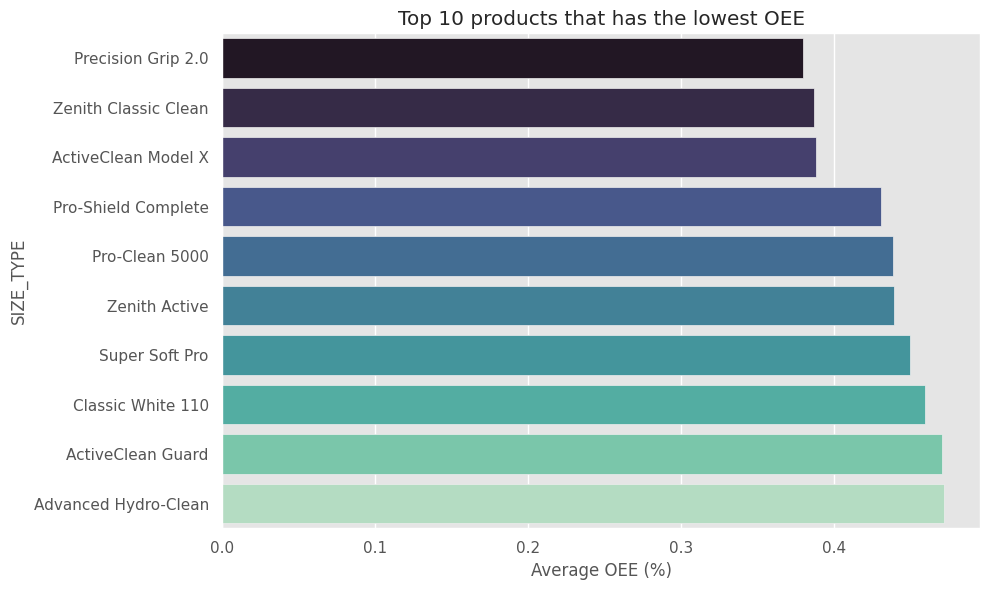

In [ ]:
OEE_with_size = OEE_df.merge(
    final_df[['LINE_NAME', 'SIZE_TYPE']].drop_duplicates(),
    on='LINE_NAME',
    how='left'
)

top_products = (
    OEE_with_size.groupby('SIZE_TYPE')['OEE']
    .mean()
    .sort_values(ascending=True)
    .head(10)
)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_products.values, y=top_products.index, palette='mako')
plt.title('Top 10 products that has the lowest OEE')
plt.xlabel('Average OEE (%)')
plt.ylabel('SIZE_TYPE')
plt.tight_layout()
plt.show()

## C2. Top 10 products that has the highest downtime

In [ ]:
downtime_df.columns

Index(['LINE_NAME', 'PRODUCTIONDATE_DAY_LOC', 'SHIFT_NAME', 'total_downtime',
       'downtime_rate'],
      dtype='object')

/tmp/ipython-input-2725444500.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


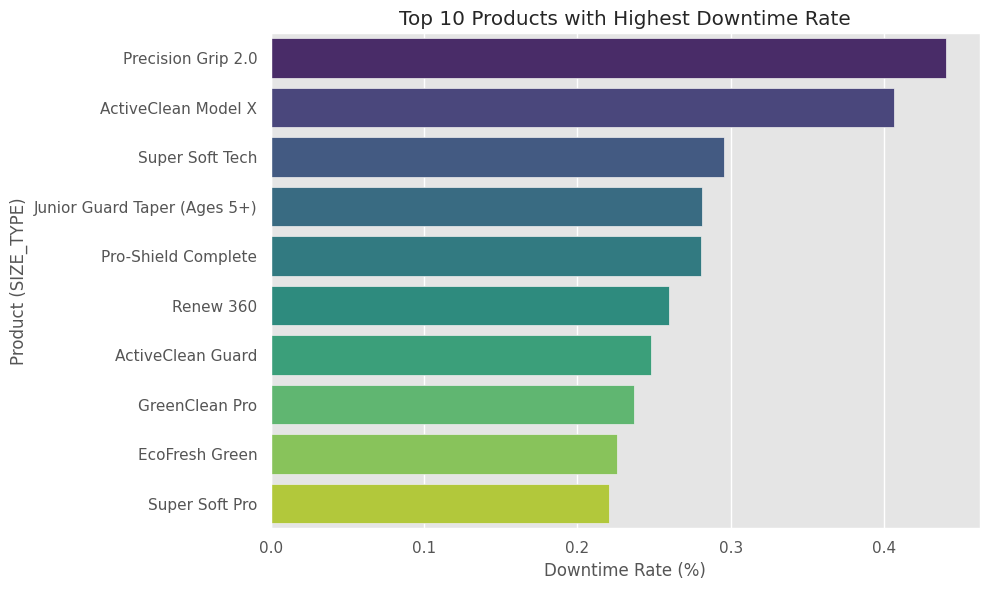

In [ ]:
downtime_rate_by_product = (
    final_df.groupby('SIZE_TYPE')
    .agg(
        total_downtime=('DOWNTIME', 'sum'),
        total_runtime=('RUN_TIME', 'sum')
    )
    .assign(
        downtime_rate=lambda x: x['total_downtime'] / (x['total_downtime'] + x['total_runtime'])
    )
    .sort_values('downtime_rate', ascending=False)
    .head(10)
)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x='downtime_rate',
    y=downtime_rate_by_product.index,
    data=downtime_rate_by_product,
    palette='viridis'
)
plt.title('Top 10 Products with Highest Downtime Rate')
plt.xlabel('Downtime Rate (%)')
plt.ylabel('Product (SIZE_TYPE)')
plt.tight_layout()
plt.show()

## C3. Top 10 products that have highest defect rate

/tmp/ipython-input-2370726130.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=defect_by_product.reset_index(),


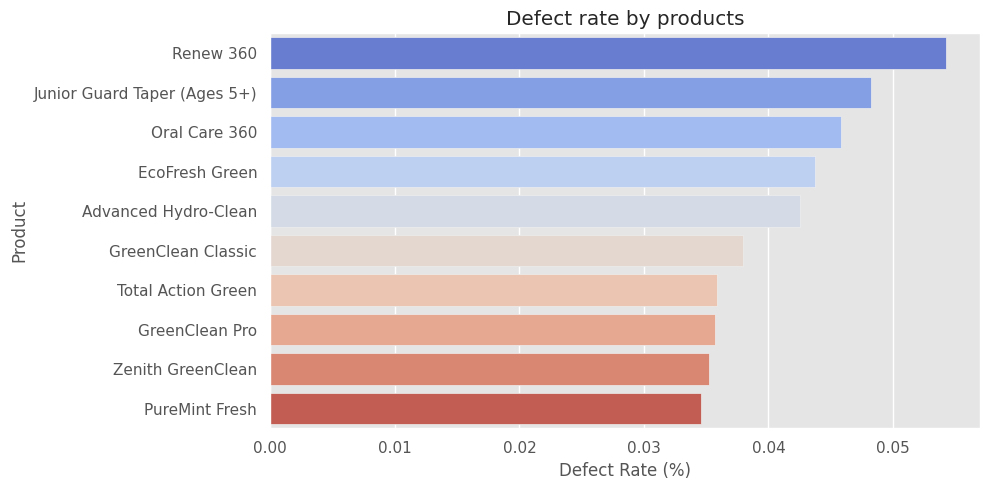

In [ ]:
final_df['defect_rate'] = final_df['REJECT_PRODUCTION_QTY'] / (
    final_df['GOOD_PRODUCTION_QTY'] + final_df['REJECT_PRODUCTION_QTY']
)
defect_by_product = final_df.groupby('SIZE_TYPE')['defect_rate'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
sns.barplot(data=defect_by_product.reset_index(),
            x='defect_rate',
            y='SIZE_TYPE',
            palette='coolwarm')
plt.title('Defect rate by products')
plt.xlabel('Defect Rate (%)')
plt.ylabel('Product')
plt.tight_layout()
plt.show()

## C4: MTBF and MTTR by products

In [ ]:
mtbf_mttr_byproduct = (
    final_df.groupby('SIZE_TYPE')
    .agg(
        total_downtime=('DOWNTIME', 'sum'),
        total_runtime=('RUN_TIME', 'sum'),
        downtime_events=('DOWNTIME', lambda x: (x > 0).sum())
    )
    .assign(
        MTBF=lambda x: x['total_runtime'] / x['downtime_events'],
        MTTR=lambda x: x['total_downtime'] / x['downtime_events']
    )
    .reset_index() )


/tmp/ipython-input-2375533329.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-2375533329.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


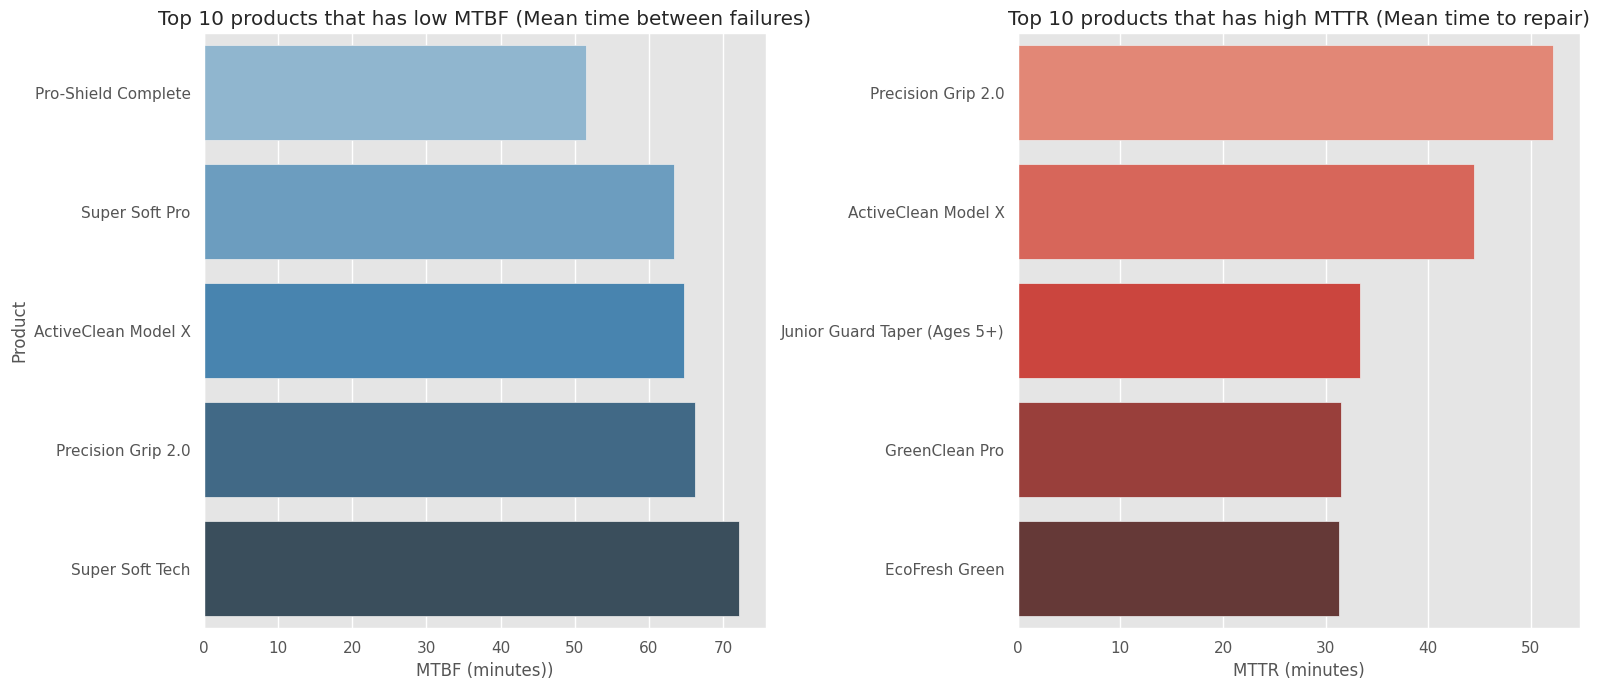

In [ ]:
#  Remove unknown products
filtered = mtbf_mttr_byproduct[mtbf_mttr_byproduct['SIZE_TYPE'] != 'Unknown']

# Filter top 10 products that has lowest MTBF (the products that is failed frequently)
top_mtbf = filtered.sort_values('MTBF', ascending=True).head(5)

# Filter top 10 products that has high MTTR (the products that costs more time to repair)
top_mttr = filtered.sort_values('MTTR', ascending=False).head(5)

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot MTBF
sns.barplot(
    data=top_mtbf,
    x='MTBF', y='SIZE_TYPE',
    palette='Blues_d', ax=axes[0]
)
axes[0].set_title('Top 10 products that has low MTBF (Mean time between failures)')
axes[0].set_xlabel('MTBF (minutes))')
axes[0].set_ylabel('Product')

# Biểu đồ MTTR
sns.barplot(
    data=top_mttr,
    x='MTTR', y='SIZE_TYPE',
    palette='Reds_d', ax=axes[1]
)
axes[1].set_title('Top 10 products that has high MTTR (Mean time to repair)')
axes[1].set_xlabel('MTTR (minutes)')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

The products **Precision Grip 2.0** and *ActiveClean Model *X are the primary drivers of maintenance problems:

- Low MTBF (Frequent Failures): They fail frequently (around 60-70 minutes).

- High MTTR (Long Repairs): They take the longest to fix (MTTR around 42-50 minutes)

Quality Priority: Renew 360 and Junior Guard Taper are the top priority for quality control intervention due to their extremely high defect rates.

## D. Analysis of downtime by reason

In [ ]:
downtime_summary = (
    final_df[final_df['AE_MODEL_CATEGORY'] == 'Unplanned']
    .groupby('UTIL_REASON_DESCRIPTION')
    .agg(
        total_downtime=('DOWNTIME', 'sum'),
        avg_downtime=('DOWNTIME', 'mean'),
        frequency=('DOWNTIME', 'count')
    )
    .reset_index()
)




/tmp/ipython-input-4041246163.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10_downtime,


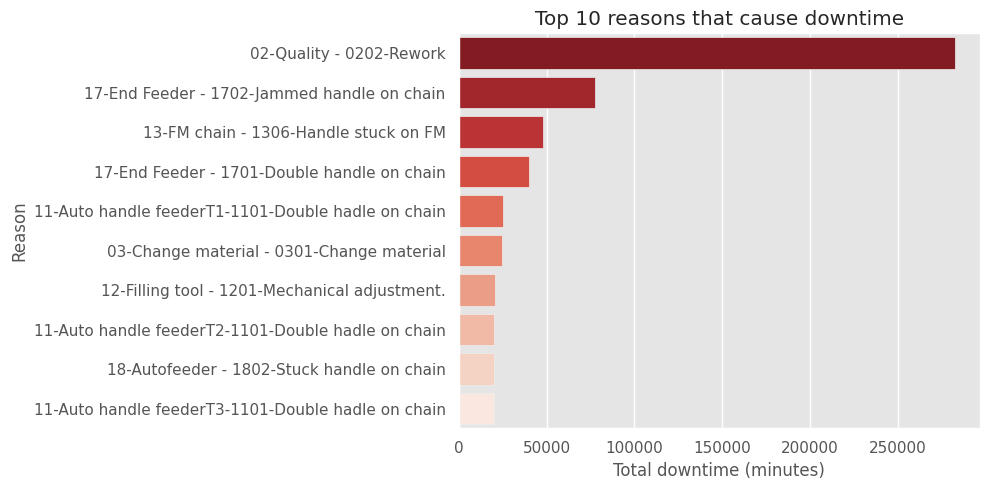

In [ ]:
top10_downtime = downtime_summary.sort_values('total_downtime', ascending=False).head(10)

plt.figure(figsize=(10,5))
sns.barplot(data=top10_downtime,
            x='total_downtime',
            y='UTIL_REASON_DESCRIPTION',
            palette='Reds_r')

plt.title('Top 10 reasons that cause downtime')
plt.xlabel('Total downtime (minutes)')
plt.ylabel('Reason')
plt.tight_layout()
plt.show()

Rework/Quality is the Dominant Bottleneck: This single quality/rework reason must be the immediate focus for root cause analysis and corrective action, as fixing it would provide the largest impact on reducing downtime.

=> This is why Quality is highest in OEE component but low performance in OEE components

# **Overall Conclusion**

## **Systemic Issue: Reactive Maintenance and Quality Rework Culture**

- The factory operates reactively — both in maintenance and quality management — leading to major production inefficiencies.

- Evidence: Planned Maintenance accounts for only 10–12% of total maintenance time, causing unplanned downtime to dominate across top lines. Meanwhile, “02-Quality – 0202-Rework” is the leading downtime reason, reflecting extensive post-production corrections.

- Implication: Maintenance and quality efforts are both triggered after failures occur, rather than through preventive actions.

- Conclusion: A shift toward predictive maintenance and in-process quality control is critical to reduce rework-driven downtime and improve overall equipment reliability.

## **Emerging issues from Time Series Analysis**

- Time-series analysis reveals rising instability in production performance, driven by erratic downtime patterns and inconsistent OEE trends. The Night-3 shift shows extreme spikes in Downtime Rate (up to ~50% in Feb–Mar), suggesting gaps in maintenance coverage or operator expertise during night operations.

- Across all shifts, OEE fluctuates sharply between ~0.40–0.70, reflecting poor process consistency and forecasting challenges. Moreover, a subtle downward drift in OEE peaks and more frequent downtime spikes indicate gradual deterioration in equipment reliability.

=> **Priority:** Systemic Issue by solving Reactive Maintenance andQuality Rework
This should be the top priority since it’s the root cause of downtime and volatility. Fixing it will stabilize OEE across all lines and shifts.




## Question 3

In order to quantify the business impact of these inefficiencies, we have used Vector Autoregression Models (VAR) to discover the impacts of such issues to downtime and defect rates over time.

* The core strength of a VAR model is that it treats all variables in the system as endogenous (mutually dependent). This means that each variable in the model is explained by its own past values and the past values of all other variables in the system.

* How VAR is able to quantify Business Impact: In a manufacturing or operational setting, the VAR model is instrumental in quantifying business impact by identifying causal relationships and dynamic responses among key performance indicators (KPIs) over time.

## VECTOR AUTOREGRESSION MODEL

In [ ]:
va_df = (
    final_df[['PRODUCTIONDATE_DAY_LOC', 'DOWNTIME', 'defect_rate', 'RUN_TIME','CHANGEOVER_DURATION']]
    .groupby('PRODUCTIONDATE_DAY_LOC', as_index=False)
    .sum()
    .copy()
)

In [ ]:
OEE_daily = (
    OEE_df.groupby('PRODUCTIONDATE_DAY_LOC', as_index=False)
    .agg({
        'Availability': 'mean',
        'Performance': 'mean',
        'Quality': 'mean'
    })
)

# Convert PRODUCTIONDATE_DAY_LOC in va_df to datetime
va_df['PRODUCTIONDATE_DAY_LOC'] = pd.to_datetime(va_df['PRODUCTIONDATE_DAY_LOC'])

# Merge with va_df
merged_va = va_df.merge(OEE_daily, on='PRODUCTIONDATE_DAY_LOC', how='left')
merged_va.set_index('PRODUCTIONDATE_DAY_LOC', inplace=True)

merged_va.head()

,DOWNTIME,defect_rate,RUN_TIME,CHANGEOVER_DURATION,Availability,Performance,Quality
PRODUCTIONDATE_DAY_LOC,,,,,,,
2025-01-01,0,0.000000,0,0,NaN,NaN,NaN
2025-01-02,7826,3.988835,42764,949,0.844818,0.609193,0.968026
2025-01-03,7723,2.801574,43596,586,0.854666,0.606049,0.977889
2025-01-04,7745,3.725814,44170,874,0.849166,0.615090,0.970496
2025-01-05,6640,2.203493,43364,838,0.866574,0.605499,0.981793


In [ ]:
merged_va.isna().sum()

,0
DOWNTIME,0
defect_rate,0
RUN_TIME,0
CHANGEOVER_DURATION,0
Availability,28
Performance,28
Quality,28


In [ ]:
merged_va.dropna(inplace=True)

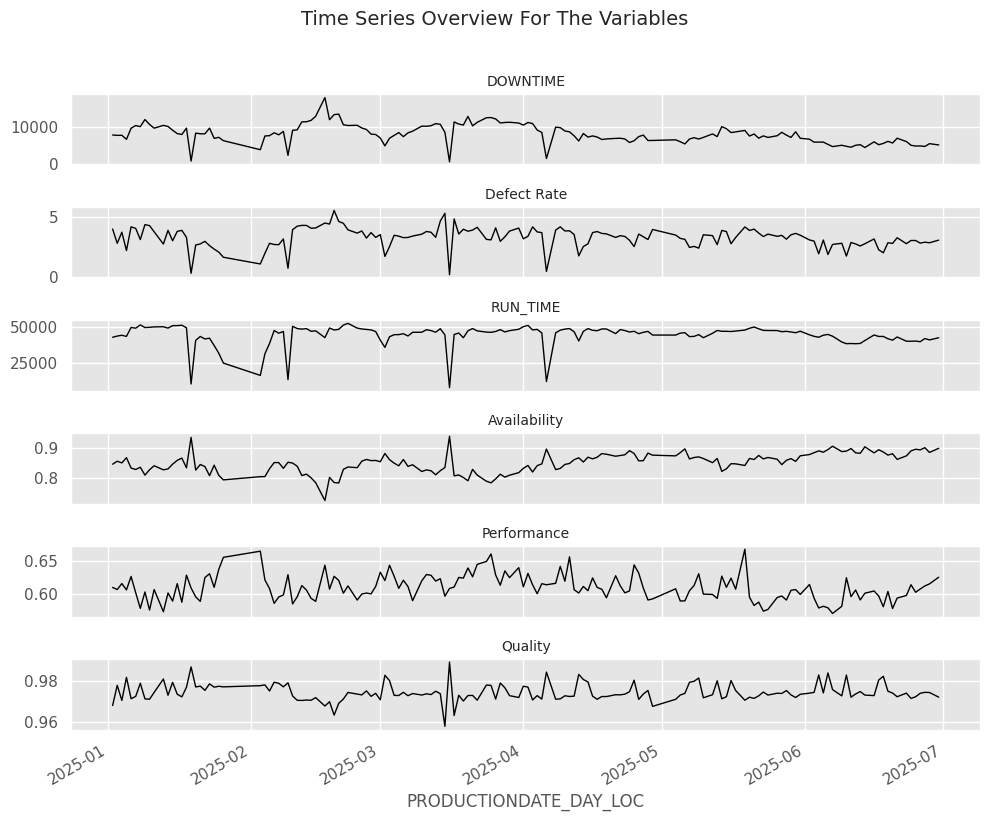

In [ ]:
plt.style.use('ggplot')  # Clean gray theme

# Create the subplots
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(10, 8), sharex=True)

# Plot each series and set its title
merged_va['DOWNTIME'].plot(ax=axes[0], color='black', linewidth=1)
axes[0].set_title('DOWNTIME', fontsize=10)

merged_va['defect_rate'].plot(ax=axes[1], color='black', linewidth=1)
axes[1].set_title('Defect Rate', fontsize=10)

merged_va['RUN_TIME'].plot(ax=axes[2], color='black', linewidth=1)
axes[2].set_title('RUN_TIME', fontsize=10)

merged_va['Availability'].plot(ax=axes[3], color='black', linewidth=1)
axes[3].set_title('Availability', fontsize=10)

merged_va['Performance'].plot(ax=axes[4], color='black', linewidth=1)
axes[4].set_title('Performance', fontsize=10)

merged_va['Quality'].plot(ax=axes[5], color='black', linewidth=1)
axes[5].set_title('Quality', fontsize=10)
# Add overall title
plt.suptitle('Time Series Overview For The Variables', fontsize=14, y=1.02)


# Adjust layout
plt.tight_layout()
plt.show()

<Axes: >

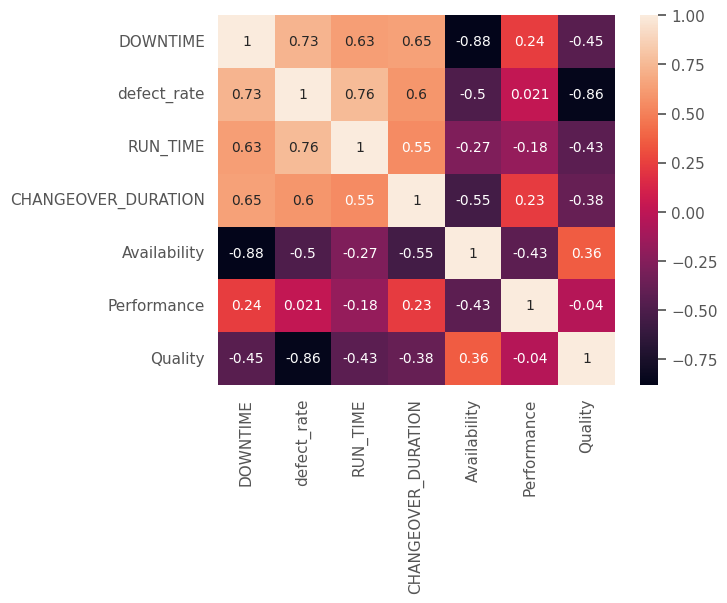

In [ ]:
sns.heatmap(merged_va.corr(), annot=True)

In [ ]:
from statsmodels.tsa.stattools import adfuller
# Confirm stationarity
for col in merged_va.columns:
    p = adfuller(merged_va[col])[1]
    print(f"{col}: p-value={p:.4f}")

DOWNTIME: p-value=0.0371
defect_rate: p-value=0.0016
RUN_TIME: p-value=0.0000
CHANGEOVER_DURATION: p-value=0.3318
Availability: p-value=0.1078
Performance: p-value=0.0000
Quality: p-value=0.0000


After confirming all variables to be stationary, except for Changeover_duration and Availabilit

In [ ]:
merged_va['Availability'] = merged_va['Availability'].diff()
merged_va['CHANGEOVER_DURATION'] = np.log(merged_va['CHANGEOVER_DURATION'])
merged_va.dropna(inplace=True)

In [ ]:
from statsmodels.tsa.stattools import adfuller
# Confirm stationarity
for col in merged_va.columns:
    p = adfuller(merged_va[col])[1]
    print(f"{col}: p-value={p:.4f}")

DOWNTIME: p-value=0.0369
defect_rate: p-value=0.0016
RUN_TIME: p-value=0.0000
CHANGEOVER_DURATION: p-value=0.0000
Availability: p-value=0.0000
Performance: p-value=0.0000
Quality: p-value=0.0000


In [ ]:
merged_va

,DOWNTIME,defect_rate,RUN_TIME,CHANGEOVER_DURATION,Availability,Performance,Quality
PRODUCTIONDATE_DAY_LOC,,,,,,,
2025-01-03,7723,2.801574,43596,6.373320,0.009847,0.606049,0.977889
2025-01-04,7745,3.725814,44170,6.773080,-0.005500,0.615090,0.970496
2025-01-05,6640,2.203493,43364,6.731018,0.017408,0.605499,0.981793
2025-01-06,9666,4.172475,49656,7.038784,-0.034755,0.625894,0.971343
2025-01-07,10404,4.045850,49108,6.786717,-0.004748,0.601218,0.972466
...,...,...,...,...,...,...,...
2025-06-25,4812,3.036563,40081,5.765191,0.005629,0.601886,0.972296
2025-06-26,4836,2.819494,39644,6.030685,-0.002073,0.606893,0.973996
2025-06-27,4695,2.897661,41873,5.805135,0.007209,0.611451,0.974465


In [ ]:
from statsmodels.tsa.api import VAR
# Pass exog into VAR model constructor
model = VAR(merged_va)

for p in range(1, 10):
    try:
        results = model.fit(p)
        print(f"Lag {p} | AIC: {results.aic:.4f}, BIC: {results.bic:.4f}")
    except np.linalg.LinAlgError:
        print(f"Lag {p} failed due to non-positive definite matrix.")

Lag 1 | AIC: -2.6995, BIC: -1.5805
Lag 2 | AIC: -2.5779, BIC: -0.4704
Lag 3 | AIC: -2.3026, BIC: 0.8022
Lag 4 | AIC: -2.0298, BIC: 2.0812
Lag 5 | AIC: -1.9977, BIC: 3.1288
Lag 6 | AIC: -1.7945, BIC: 4.3566
Lag 7 | AIC: -1.9170, BIC: 5.2683
Lag 8 | AIC: -1.9292, BIC: 6.2997
Lag 9 | AIC: -1.8981, BIC: 7.3841


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
# Fit the model using the AIC-recommended lag order
fitted_model = model.fit(maxlags=1)

# Print summary
print(fitted_model.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 22, Oct, 2025
Time:                     15:51:54
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -1.58046
Nobs:                     151.000    HQIC:                  -2.24486
Log likelihood:          -1240.01    FPE:                  0.0672890
AIC:                     -2.69945    Det(Omega_mle):       0.0468816
--------------------------------------------------------------------
Results for equation DOWNTIME
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                    -403945.969428    127776.354505           -3.161           0.002
L1.DOWNTIME                    0.816133         0.119890            6.807           0.000
L1.defect_rate       

### Check stability of the model

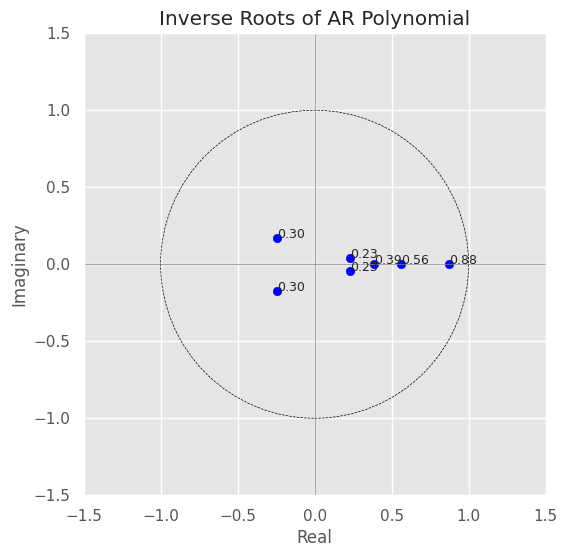

In [ ]:
# Get inverse roots
roots = fitted_model.roots
inv_roots = 1 / roots

# Plotting inverse roots
fig, ax = plt.subplots(figsize=(6, 6))
circle = plt.Circle((0, 0), 1, color='black', fill=False, linestyle='--')
ax.add_artist(circle)

# Plot each root
ax.scatter(inv_roots.real, inv_roots.imag, c='blue')
for i, root in enumerate(inv_roots):
    ax.text(root.real, root.imag, f'{np.abs(root):.2f}', fontsize=9)

ax.set_title("Inverse Roots of AR Polynomial")
ax.set_xlabel("Real")
ax.set_ylabel("Imaginary")
ax.axhline(0, color='gray', lw=0.5)
ax.axvline(0, color='gray', lw=0.5)
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_aspect('equal')
plt.grid(True)
plt.show()

All inverse roots lie within the unit circle, confirming that the AR model is stable and suitable for forecasting.

In [ ]:
from statsmodels.stats.diagnostic import breaks_cusumolsresid

test_stat, cusum_values, confint = breaks_cusumolsresid(fitted_model.resid, ddof=0)
print("Test Statistic:", test_stat)
print("CUSUM Values:", cusum_values)
print("Confidence Intervals:", confint)

Test Statistic: 1.0495386918673966
CUSUM Values: 0.2206307999065406
Confidence Intervals: [(1, 1.63), (5, 1.36), (10, 1.22)]


The residual diagnostics suggest that the model is statistically sound:

In [ ]:
whiteness_test = fitted_model.test_whiteness(nlags = 10)
print(whiteness_test.summary())

Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 10 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value  df
-----------------------------------------
         484.2          491.0   0.076 441
-----------------------------------------


the whiteness test indicates no significant autocorrelation in residuals

In [ ]:
from statsmodels.stats.stattools import durbin_watson
residuals = fitted_model.resid
dw_stat = durbin_watson(residuals)
print(f"Durbin-Watson statistic: {dw_stat}")

Durbin-Watson statistic: [2.07996818 1.90418637 1.95842405 1.95866475 2.05267204 2.10739049
 1.86158657]


the Durbin–Watson statistics (mostly around 2.0) confirm that residuals are approximately uncorrelated, supporting model adequacy and stability.

In [ ]:
cov = fitted_model.sigma_u
print("Covariance matrix:\n", cov)
print("\nEigenvalues:\n", np.linalg.eigvals(cov))

Covariance matrix:
                          DOWNTIME  defect_rate      RUN_TIME  \
DOWNTIME             3.006265e+06   855.219816  8.480328e+06   
defect_rate          8.552198e+02     0.518498  3.530367e+03   
RUN_TIME             8.480328e+06  3530.367437  4.409205e+07   
CHANGEOVER_DURATION  9.671231e+02     0.386851  4.359191e+03   
Availability        -2.914546e+01    -0.006754 -5.294913e+01   
Performance          4.875008e+00     0.000190 -1.874075e+01   
Quality             -2.773576e+00    -0.002477 -9.859761e+00   

                     CHANGEOVER_DURATION  Availability  Performance   Quality  
DOWNTIME                      967.123058    -29.145457     4.875008 -2.773576  
defect_rate                     0.386851     -0.006754     0.000190 -0.002477  
RUN_TIME                     4359.190697    -52.949130   -18.740752 -9.859761  
CHANGEOVER_DURATION             0.659518     -0.009146     0.001195 -0.001425  
Availability                   -0.009146      0.000415    -0.000128

In [ ]:
from statsmodels.tsa.vector_ar.var_model import FEVD
fevd = FEVD(fitted_model, periods=10)
fevd.summary()

FEVD for DOWNTIME
     DOWNTIME  defect_rate  RUN_TIME  CHANGEOVER_DURATION  Availability  Performance   Quality
0    1.000000     0.000000  0.000000             0.000000      0.000000     0.000000  0.000000
1    0.824226     0.047668  0.019232             0.041793      0.013475     0.002254  0.051353
2    0.786140     0.054121  0.046068             0.036808      0.015819     0.010596  0.050447
3    0.739833     0.065057  0.072179             0.033746      0.017672     0.015534  0.055978
4    0.706594     0.072404  0.092246             0.031156      0.018920     0.019778  0.058903
5    0.681812     0.077946  0.107448             0.029283      0.019679     0.022878  0.060953
6    0.663310     0.082147  0.118739             0.027964      0.020210     0.025169  0.062461
7    0.649631     0.085260  0.127116             0.027027      0.020576     0.026871  0.063518
8    0.639440     0.087593  0.133350             0.026352      0.020837     0.028134  0.064293
9    0.631828     0.089339  0.13

**Insight from Forecast Error Variance Decomposition**

- Downtime – Mostly Self-Driven, Influenced by Quality
Downtime is highly inertial — after 9 periods, 63.2% of its variance comes from its own shocks. Quality is the main external driver (6.5%), confirming Granger causality results.

- Defect Rate – Driven by Downtime and Itself
Defect rate volatility stems mainly from Downtime (42.7%) and its own shocks (37.2%). Reducing Downtime instability is key to improving quality stability.

- Performance – Largely Self-Driven
Performance depends primarily on itself (59.7%), with RUN_TIME as the main external factor (15.5%). Stabilizing RUN_TIME improves overall performance stability.

- Availability – Strongly Tied to Downtime
Availability’s unpredictability is driven by DOWNTIME (60.5%) and its own shocks (11.2%). Reducing Downtime volatility is essential to stabilize Availability.

Downtime directly reduces machine uptime, meaning lines spend less time in productive operation, which means persistent or recurring downtime patterns can create systemic availability losses, especially if maintenance recovery is slow (high MTTR), which is further proved in Forecast Error Decomposition Variances (FEVD) when Downtime variations explain nearly 70% of variations in Availability during initial periods

High defect rates lead to frequent stops for rework, cleaning, , which reduces available runtime even when machines are technically "on". This is further proved when FEVD shows that variance of defect rates explain nearly 20% of Availability variances, only behind Downtime.

Thus, both variables act as leading indicators of availability degradation — poor quality and unstable operations today reduce production uptime tomorrow.

## Calculate the total potential production units lost during downtime and estimate the scale of material loss

In [ ]:
df.columns

Index(['PRODUCTIONDATE_DAY_LOC', 'SHIFT_NAME', 'LINE_NAME', 'CO_TYPE',
       'CREW_ID', 'AE_MODEL_CATEGORY', 'SIZE_TYPE', 'SHIFT_NAME.1',
       'UTIL_REASON_DESCRIPTION', 'DOWNTIME', 'EFFECTIVE_RUNTIME',
       'GOOD_PRODUCTION_QTY', 'LUNCH_AND_BREAK', 'MEETING_AND_TRAINING',
       'NO_DEMAND', 'PLANT_AVAILABLE_TIME', 'PLANT_EXPERIMENTATION',
       'PRODUCTION_AVAILABLE_TIME', 'REJECT_PRODUCTION_QTY', 'RUN_TIME',
       'CHANGEOVER_DURATION', 'CLEANING_AND_SANITIZATION',
       'BUSINESS_EXTERNAL_TIME', 'PLANNED_MAINTENANCE', 'TOTAL_TIME',
       'WAITING_TIME', 'PRODUCTION_ORDER_RATE', 'EQUIPMENT_ID', 'total_orders',
       'first_date', 'last_date', 'avg_days_between_maintenance', 'ORDER_TYPE',
       'DESCRIPTION', 'OPERA NAME', 'total_equipment_id', 'Ideal_cycle_time',
       'Total_Production_Qty', 'Performance', 'defect_rate', 'Ideal_Output',
       'Actual_Output', 'Potential_Unit_Loss'],
      dtype='object')

In [ ]:
df = final_df.copy()
df = df[df['Ideal_cycle_time'] > 0]

# Step 1: Calculate Ideal Output (no downtime)
df['Ideal_Output'] = df['PRODUCTION_AVAILABLE_TIME'] / df['Ideal_cycle_time']

# Step 2: Calculate Actual Output
df['Actual_Output'] = df['GOOD_PRODUCTION_QTY'] + df['REJECT_PRODUCTION_QTY']

# Step 3: Calculate Potential Units Lost
df['Potential_Unit_Loss'] = df['Ideal_Output'] - df['Actual_Output']

# Optional: Prevent negative due to rounding
df['Potential_Unit_Loss'] = df['Potential_Unit_Loss']

# Step 4: Aggregate by machines
loss_summary = (
    df.groupby('LINE_NAME', as_index=False)
    .agg({
        'Potential_Unit_Loss': 'sum',
        'GOOD_PRODUCTION_QTY': 'sum',
        'REJECT_PRODUCTION_QTY': 'sum',
        'PRODUCTION_AVAILABLE_TIME': 'sum',
        'DOWNTIME': 'sum'
    })
)

loss_summary['Defective_Units'] = loss_summary['REJECT_PRODUCTION_QTY']
loss_summary['Defect_Rate'] = (
    loss_summary['REJECT_PRODUCTION_QTY'] /
    (loss_summary['GOOD_PRODUCTION_QTY'] + loss_summary['REJECT_PRODUCTION_QTY'])
)

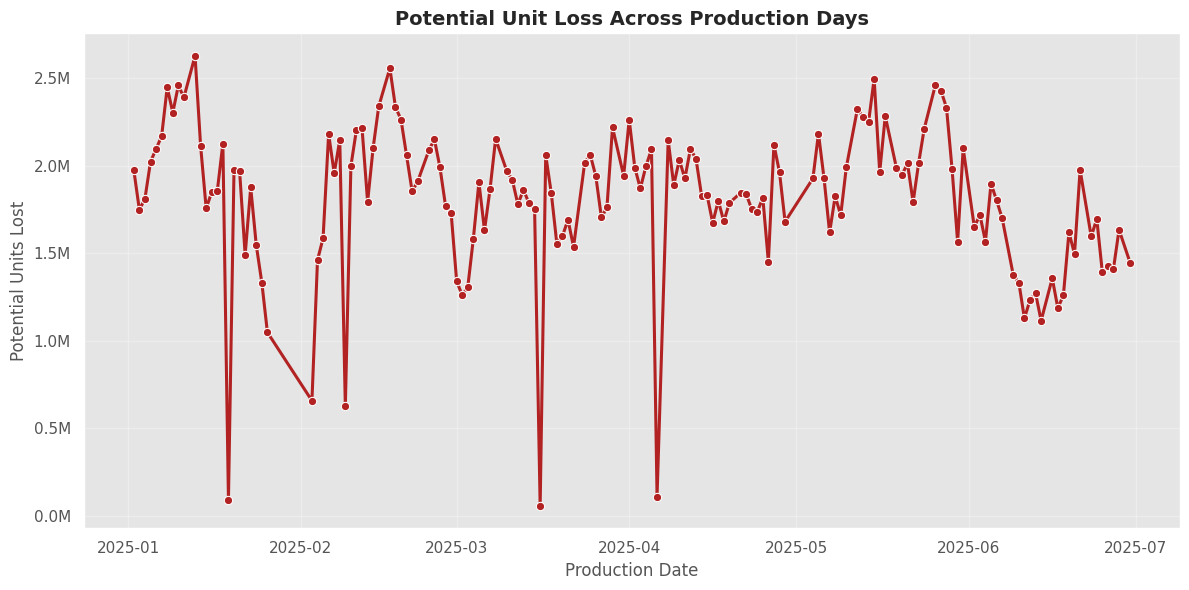

In [ ]:
# Step 2: Aggregate by production day
daily_loss = (
    df.groupby('PRODUCTIONDATE_DAY_LOC', as_index=False)
    .agg({'Potential_Unit_Loss': 'sum'})
)

# Step 3: Convert date column to datetime
daily_loss['PRODUCTIONDATE_DAY_LOC'] = pd.to_datetime(daily_loss['PRODUCTIONDATE_DAY_LOC'])

# Step 4: Plot

plt.figure(figsize=(12,6))
sns.lineplot(
    data=daily_loss,
    x='PRODUCTIONDATE_DAY_LOC',
    y='Potential_Unit_Loss',
    marker='o',
    color='firebrick',
    linewidth=2.2
)

plt.title('Potential Unit Loss Across Production Days', fontsize=14, weight='bold')
plt.xlabel('Production Date', fontsize=12)
plt.ylabel('Potential Units Lost', fontsize=12)
plt.ticklabel_format(style='plain', axis='y')
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1_000_000:.1f}M'))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

The big swings in potential loss show that production isn’t running steadily — downtime and speed losses are happening too often. The slight improvement later on hints that fixes are starting to work, but the process still isn’t stable enough to sustain high performance.

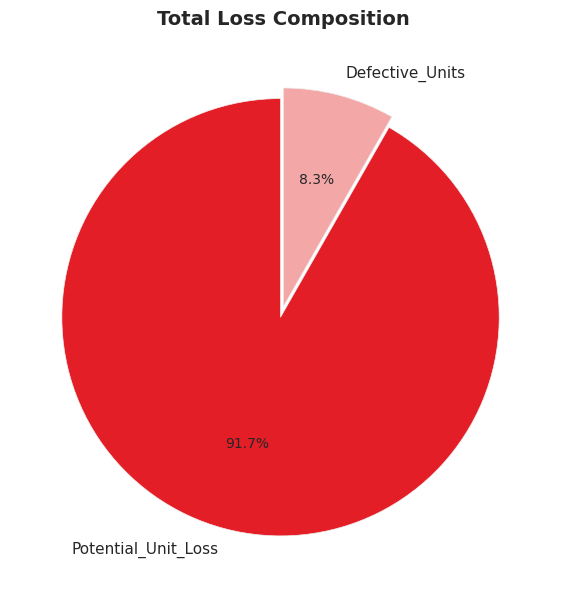

In [ ]:
plt.figure(figsize=(6,6))
plt.pie(
    total_loss,
    labels=total_loss.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=['#E41E26', '#F4A7A7'],
    explode=[0.05, 0]
)
plt.title('Total Loss Composition', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

Most losses come from unrealized production rather than defects, meaning the main issue isn’t quality, it’s efficiency. Improving runtime stability and cutting downtime would recover far more output than focusing only on defect reduction.